In [1]:
from train import train_vqvae, DEVICE, train_pixel_cnn, test_pixel_cnn
from predict import generate_samples
from modules.vqvae import VQVAE
from modules.pixelcnn import PixelCNN
from dataset import train_dl, test_dl, batch_size, test_set, PixelCNNData
from torch.utils.data import DataLoader
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def show(img):
    """
    Plotting func
    """
    np_img = img.numpy()
    fig = plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [2]:
model = VQVAE(latent_dim=128, res_h_dim=32, num_embeddings=512, embedding_dim=64, beta=0.25)
model.to(DEVICE)
EPOCHS = 2

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
training_reconstruction_loss = []
for i in range(EPOCHS):
    print(f"=======================EPOCH = {i + 1}======================")
    loss = train_vqvae(dl=train_dl, model=model, optim=optim)
    training_reconstruction_loss.append(loss)
    print(f"Reconstruction loss: {loss}")

=======================EPOCH = 1======================
batch    0/354 	 |current loss: 0.807003
batch   25/354 	 |current loss: 0.532948
batch   50/354 	 |current loss: 0.308322
batch   75/354 	 |current loss: 0.336627
batch  100/354 	 |current loss: 0.248623
batch  125/354 	 |current loss: 0.203222
batch  150/354 	 |current loss: 0.121747
batch  175/354 	 |current loss: 0.166472
batch  200/354 	 |current loss: 0.176555
batch  225/354 	 |current loss: 0.138061
batch  250/354 	 |current loss: 0.189433
batch  275/354 	 |current loss: 0.237457
batch  300/354 	 |current loss: 0.125128
batch  325/354 	 |current loss: 0.108246
batch  350/354 	 |current loss: 0.150739
Reconstruction loss: 0.23556041077705425
=======================EPOCH = 2======================
batch    0/354 	 |current loss: 0.103885
batch   25/354 	 |current loss: 12.274344
batch   50/354 	 |current loss: 0.583294
batch   75/354 	 |current loss: 0.172976
batch  100/354 	 |current loss: 0.148386
batch  125/354 	 |current lo

In [29]:
# save the model
torch.save(model, './results/vqvae.pth')

In [3]:
# load model
model = torch.load('./results/vqvae.pth')
model = model.to(DEVICE)

In [4]:
test_real = next(iter(test_dl))  # load some from test dl
test_real = test_real[0]
test_real = test_real.to(DEVICE)
pre_conv = model.pre_quantization_conv(model.encoder(test_real))  # encoder, reshape
_, test_quantized, _, _ = model.vector_quantizer(pre_conv)
test_reconstructions = model.decoder(test_quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


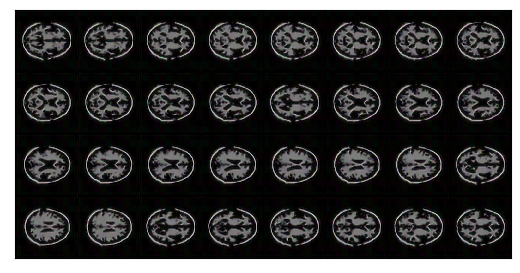

In [5]:
# show reconstructed images
show(torchvision.utils.make_grid(test_reconstructions.cpu()))

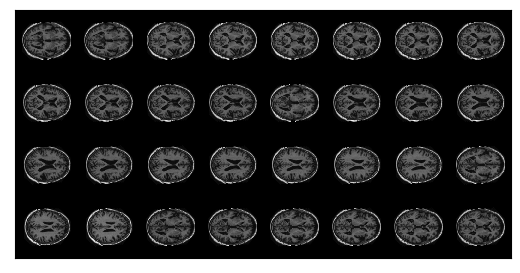

In [6]:
# show original images
show(torchvision.utils.make_grid(test_real.cpu()))

torch.Size([1, 3, 256, 256])
tensor([113, 149, 430, 461])


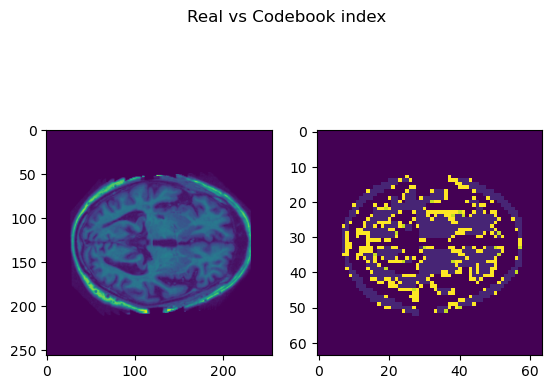

In [7]:
test_input = next(iter(test_dl))
test_input = test_input[0][0]
test_input = test_input.unsqueeze(0)
print(test_input.shape)
test_input = test_input.to(DEVICE)
test_encoded = model.encoder(test_input)
test_encoded = model.pre_quantization_conv(test_encoded)
_, test_encoded, encodings, indices = model.vector_quantizer(test_encoded)
decoded = model.decoder(test_encoded)
# Plot codebook index
plot_image = indices.view(64, 64)
print(torch.unique(indices.to('cpu')))
plot_image = plot_image.to('cpu')
detached_image = plot_image.detach().numpy()

test_input = test_input[0][0].cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Real vs Codebook index')
ax1.imshow(test_input)
ax2.imshow(detached_image)

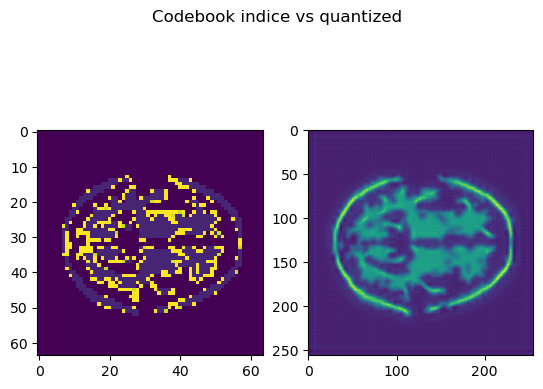

In [8]:
# Convert Codebook index to quantized
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Codebook indice vs quantized')
indices_quantized = model.vector_quantizer.get_quantized(indices)
decoded_quantized_indices = model.decoder(indices_quantized)
immi = decoded_quantized_indices[0]
immi = immi.to('cpu')
immi = immi.detach().numpy()
ax2.imshow(immi[1])
ax1.imshow(indices.cpu().view(64, 64).detach().numpy())

In [5]:
pixel_cnn_ds = PixelCNNData(model, torchvision.transforms.ToTensor())
pixel_cnn_dl = DataLoader(pixel_cnn_ds, batch_size=32)

In [6]:
pixel_cnn = PixelCNN().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

TypeError: __init__() takes from 4 to 6 positional arguments but 7 were given

In [ ]:
BEST_LOSS = 999
LAST_SAVED = -1
cnn_epochs = 5
generated = []
for epoch in range(1, cnn_epochs):
    print("\nEpoch {}:".format(epoch))
    train_pixel_cnn(pixel_cnn, codebook_train_dl, criterion, 512, opt)
    cur_loss = test_pixel_cnn(pixel_cnn, codebook_test_dl, criterion, 512)

    if cur_loss <= BEST_LOSS:
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch

        print("Saving model!")
        torch.save(model.state_dict(), 'results/{}_pixelcnn.pt'.format(codebook_train_dl))

    generated.append(generate_samples(pixel_cnn, 256))